In [1]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
import h5py
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import json
import glob
import re

Define functions to calculate $\chi_\mathrm{eff}$ and $\chi_p$:

In [2]:
def Calculate_Xp(m1, m2, a1, a2, costilt1, costilt2):

    # Mass ratio 
    q = 1.0*m1/m2

    # Coefficients A1 and A2 
    A1 = 2 + 3/(2*q)
    A2 = 2 + 3*q/2

    # Calculating sin from cos
    sintilt1 = np.sqrt(1-(costilt1)**2)
    sintilt2 = np.sqrt(1-(costilt2)**2)

    # Terms in Xp
    term1 = A1*a1*(m1**2)*sintilt1
    term2 = A2*a2*(m2**2)*sintilt2
    coeff = 1.0/(2*A1*(m1**2))

    # Using addition of terms method 
    Xp = coeff*(term1 + term2 + np.abs(term1 - term2))

    return Xp

def Calculate_Xeff(m1, m2, a1, a2, costilt1, costilt2):
    Xeff = (m1*a1*costilt1 + m2*a2*costilt2)/(m1+m2)
    return Xeff

def eta(m1,m2):
    return m1*m2/(m1+m2)/(m1+m2)

def Mc(m1,m2):
    return np.power(eta(m1,m2),3./5.)*(m1+m2)

We'll additionally be reweighting the default LALInference mass and redshift priors with more astrophysically-motivated priors. The LALInference prior is uniform in *luminosity* distance, and uniform in *detector-frame* component masses. This corresponds to:

\begin{equation}
p_\mathrm{lal}(m_1,m_2,z) \propto (1+z)^2 D_L^2(z) \left( D_c(z) + \frac{c(1+z)}{H(z)}\right),
\end{equation}

where $D_L(z)$ and $D_c(z)$ are the luminosity and comoving distance at redshift $z$, respectively, and $H(z)$ is the Hubble parameter at $z$.

We'll reweight to a prior that assumes the (source-frame) comoving merger rate density evolves as $(1+z)^{2.7}$, and a mass prior that takes the form of a power law on $m_1$ and $q$ (once conditioned on the primary mass):

\begin{equation}
p_\mathrm{astro}(m_1,m_2,z) \propto \frac{1}{1+z} \left(1+z\right)^{2.7} \frac{dV_c}{dz} \,m_1^{-2.2}\,q^{1.3}
\end{equation}

In [3]:
c = 3.0e8          # m/s
H_0 = 67270.0      # m/s/MPc
Omega_M = 0.3156 # unitless
Omega_Lambda = 1.0-Omega_M

def Hz(z):
    return H_0*np.sqrt(Omega_M*(1.+z)**3.+Omega_Lambda)

def calculate_pLAL(z, dl):
    dc = dl/(1.+z) # comoving distance 
    pLAL = np.power(1.+z,2.)*np.power(dl,2.)*(dc+c*(1.+z)/Hz(z))
    return pLAL

def calculate_pASTRO(z, dl, m1, m2):
    dc = dl/(1.+z) # comoving distance 
    dVc_dz = 4*np.pi*c*(dc**2.)/Hz(z) # comoving volume 
    
    pz = np.power(1.+z,2.7-1.)*dVc_dz
    
    alpha = -2.2
    beta = 1.3
    mMin = 5.
    mMax = 75.
    
    pm1 = np.power(m1/(1.+z),alpha) #m1 and m2 are presumed to be in the **detector frame**
    pm2 = np.power(m2/(1.+z),beta)/(np.power(m1/(1.+z),1.+beta)-np.power(mMin,1.+beta))
    
    pASTRO = pz*pm1*pm2
    pASTRO[m2/(1.+z)<mMin] = 0.
    pASTRO[m1/(1.+z)>mMax] = 0.
    
    return pASTRO

For later use, we'll want to build an interpolant between luminosity distance and redshift:

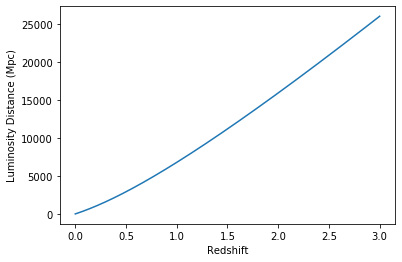

In [4]:
zs_ref = np.linspace(0.,3.,1000)
DL_ref = Planck15.luminosity_distance(zs_ref).to(u.Mpc).value

fig,ax = plt.subplots()
ax.plot(zs_ref,DL_ref)
ax.set_xlabel('Redshift')
ax.set_ylabel('Luminosity Distance (Mpc)')
plt.show()

Next, define a function to build chi-effective and chi-p priors. For every event below, we'll define a dictionary containing the mass bounds used for the given event's PE

In [5]:
def drawPriorSamples(nsamps,q,massSamps=False):
    
    m1_prior = 100.*np.ones(nsamps)
    m2_prior = q*m1_prior

    # Draw spin magnitudes and tilt angles
    a1_prior = np.random.random(nsamps)
    a2_prior = np.random.random(nsamps)
    cost1_prior = 2.*np.random.random(nsamps)-1
    cost2_prior = 2.*np.random.random(nsamps)-1

    # Compute and return effective spins
    xeff_prior = Calculate_Xeff(m1_prior,m2_prior,a1_prior,a2_prior,cost1_prior,cost2_prior)
    xp_prior = Calculate_Xp(m1_prior,m2_prior,a1_prior,a2_prior,cost1_prior,cost2_prior)
    
    if massSamps==True:
        return xeff_prior,xp_prior,m1_prior,m2_prior
    
    else:
        return xeff_prior,xp_prior

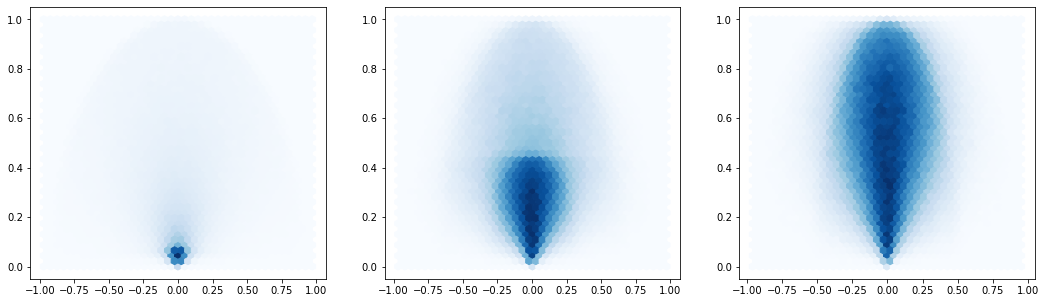

In [6]:
xeff_01,xp_01 = drawPriorSamples(1000000,0.1)
xeff_05,xp_05 = drawPriorSamples(1000000,0.5)
xeff_10,xp_10 = drawPriorSamples(1000000,1.0)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)
ax.hexbin(xeff_01,xp_01,cmap='Blues',gridsize=40)
ax = fig.add_subplot(132)
ax.hexbin(xeff_05,xp_05,cmap='Blues',gridsize=40)
ax = fig.add_subplot(133)
ax.hexbin(xeff_10,xp_10,cmap='Blues',gridsize=40)
plt.show()

Now define a function that takes generated prior samples and builds approximants to the chi-effective, chi-p, and joint spin priors. Specifically, we'll generate KDEs in all three spaces, then use the KDEs to build spline interpolants of each prior.

As we'll see below, near $\chi_p = 0$ the $\chi_\mathrm{eff}$ prior is an extremely narrow ridge. To help us resolve this ridge with our KDE, when building the joint prior we'll work with $\mathrm{logistic}(\chi_\mathrm{eff})$:

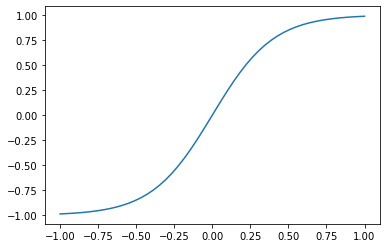

In [7]:
# Logistic transform:
def logistic(x):
    return 2./(1.+np.exp(-5.*x))-1
    
x = np.linspace(-1,1)
plt.plot(x,logistic(x))
plt.show()

Our interpolant builder:

In [8]:
def buildInterpolants(xeff_prior_samps,xp_prior_samps,demo=False):
    
    # Construct Gaussian KDEs of 1D and 2D priors:
    xeff_prior_kde = gaussian_kde(xeff_prior_samps)
    xp_prior_kde = gaussian_kde(xp_prior_samps)
    #joint_prior_kde = gaussian_kde(np.array([xeff_prior_samps,xp_prior_samps]))
    joint_prior_kde = gaussian_kde(np.array([logistic(xeff_prior_samps),xp_prior_samps]),
                                   bw_method=0.5*xeff_prior_samps.size**(-1./6.))
    
    # Chi-Eff prior interpolant
    chi_effs_to_interp = np.concatenate(([-1],np.arange(-0.99,1.,0.01),[1]))
    prob_chi_effs_to_interp = np.concatenate(([0.],xeff_prior_kde(np.arange(-0.99,1.,0.01)),[0]))
    chi_eff_norm = np.trapz(prob_chi_effs_to_interp,chi_effs_to_interp)
    chiEff_interp_function = interp1d(chi_effs_to_interp,prob_chi_effs_to_interp/chi_eff_norm,kind='cubic')

    # Chi-P prior interpolant
    chi_ps_to_interp = np.concatenate(([0],np.arange(0.02,1.0,0.02),[0.99],[1]))
    prob_chi_ps_to_interp = np.concatenate(([0],xp_prior_kde(np.arange(0.02,1.,0.02)),xp_prior_kde(0.99),[0]))
    chip_norm = np.trapz(prob_chi_ps_to_interp,chi_ps_to_interp)
    chip_interp_function = interp1d(chi_ps_to_interp,prob_chi_ps_to_interp/chip_norm,kind='cubic')
    
    # Construct XY grid for joint prior interpolater, add zeros around the edges
    x_input = np.concatenate([np.arange(-1.,-0.2,0.1),np.arange(-0.2,0.2,0.02),np.arange(0.2,1.1,0.1)])
    y_input = np.concatenate([[0.],np.arange(0.02,0.1,0.01),np.arange(0.1,1.05,0.05)])
    X,Y = np.meshgrid(x_input,y_input)
    zs = joint_prior_kde([X.reshape(-1),Y.reshape(-1)])
    zs_2d = zs.reshape(y_input.size,x_input.size)
    zs_2d[0,:] = 0.
    zs_2d[-1,:] = 0.
    zs_2d[:,0] = 0.
    zs_2d[:,-1] = 0.
    jointPriorSpline = RectBivariateSpline(x_input,y_input,zs_2d.T,kx=2,ky=2)
    
    if demo==True:
        return chiEff_interp_function,chip_interp_function,jointPriorSpline,x_input,y_input,zs_2d
    
    else:
        return chiEff_interp_function,chip_interp_function,jointPriorSpline
    
# For convenience, define a function that will move samples to the logistic domain, interpolate,
# and apply the appropriate Jacobian factor
def evaluateJointPrior(chiEff_samps,chiP_samps,joint_spline):
    joint_priors_lx = joint_spline.ev(logistic(chiEff_samps),chiP_samps)
    joint_priors = joint_priors_lx*(2.*5.*np.exp(-5.*chiEff_samps))/np.square(1.+np.exp(-5.*chiEff_samps))
    return joint_priors

Demonstration:

In [9]:
# Draw samples and get resulting interpolants
xeff_prior_samps,xp_prior_samps = drawPriorSamples(1000000,0.8)
chiEff_interp,chip_interp,joint_spline,demo_x,demo_y,demo_z = buildInterpolants(xeff_prior_samps,xp_prior_samps,demo=True)

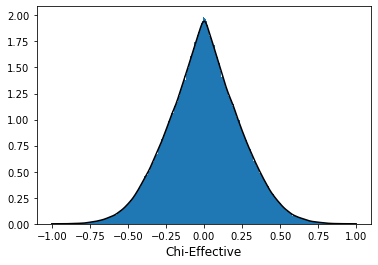

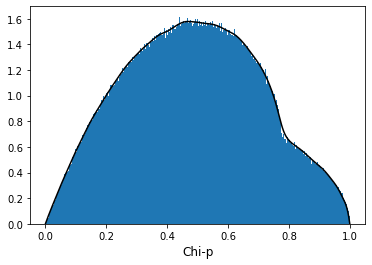

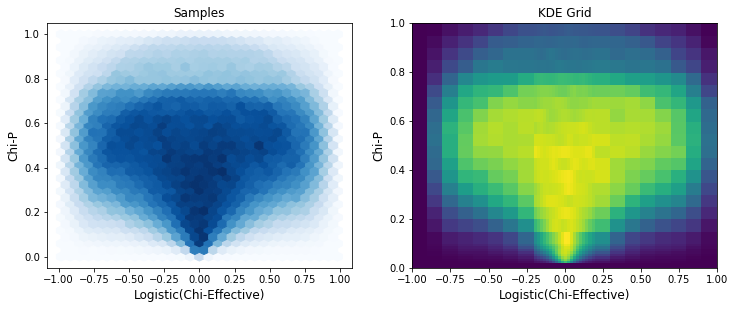

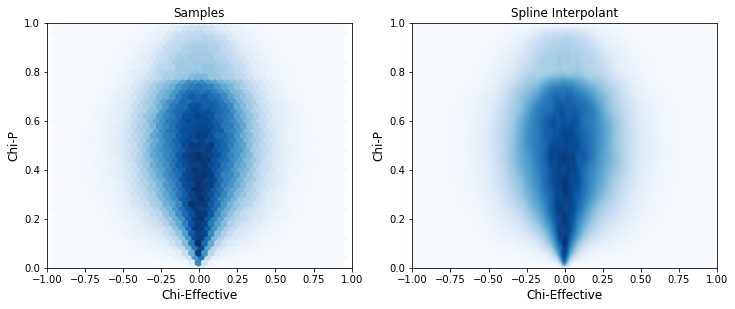

In [10]:
# Plot chi-effective samples and interpolant
fig, ax = plt.subplots()
ax.hist(xeff_prior_samps,bins=300,density=True)
ax.plot(np.linspace(-1.,1.,300),chiEff_interp(np.linspace(-1.,1.,300)),color='black')
ax.set_xlabel('Chi-Effective',fontsize=12)
plt.show()

# Plot chi-p samples and interpolant
fig, ax = plt.subplots()
n,bins,patches = ax.hist(xp_prior_samps,bins=300,density=True)
ax.plot(np.linspace(0.,1.,300),chip_interp(np.linspace(0.,1.,300)),color='black')
ax.set_xlabel('Chi-p',fontsize=12)
plt.show()

# Our joint KDE and interpolant in logistic space
fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(121)
ax.hexbin(logistic(xeff_prior_samps),xp_prior_samps,gridsize=30,cmap='Blues')
ax.set_xlabel('Logistic(Chi-Effective)',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_title('Samples',fontsize=12)

ax = fig.add_subplot(122)
ax.pcolormesh(demo_x,demo_y,demo_z)
ax.set_xlabel('Logistic(Chi-Effective)',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_title('KDE Grid',fontsize=12)

# Our joint prior moved back to chi-effective space
fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(121)
ax.hexbin(xeff_prior_samps,xp_prior_samps,gridsize=45,cmap='Blues')
ax.set_xlabel('Chi-Effective',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_title('Samples',fontsize=12)

ax = fig.add_subplot(122)
demo_grid_x = np.linspace(-1,1,1000)
demo_grid_y = np.linspace(0,1,1010)
X,Y = np.meshgrid(demo_grid_x,demo_grid_y)
demo_output = evaluateJointPrior(X.reshape(-1),Y.reshape(-1),joint_spline)
plt.pcolormesh(demo_grid_x,demo_grid_y,demo_output.reshape(demo_grid_y.size,demo_grid_x.size),cmap='Blues')
ax.set_xlabel('Chi-Effective',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_title('Spline Interpolant',fontsize=12)

plt.show()

In [11]:
reference_qs = np.linspace(0.01,1.0,40)
reference_splines = []
reference_chiEff_interps = []
reference_chiP_interps = []
for ref_q in reference_qs:
    print(ref_q)
    
    xeff_prior_samps,xp_prior_samps = drawPriorSamples(1000000,ref_q)
    chiEff_interp_function,chip_interp_function,jointPriorSpline = buildInterpolants(xeff_prior_samps,xp_prior_samps)
    reference_splines.append(jointPriorSpline)
    reference_chiEff_interps.append(chiEff_interp_function)
    reference_chiP_interps.append(chip_interp_function)
    
np.save('./preprocessed-single-events/priors.npy',\
        np.array([reference_qs,reference_splines,reference_chiEff_interps,reference_chiP_interps]))

0.01
0.03538461538461538
0.06076923076923077
0.08615384615384615
0.11153846153846153
0.13692307692307693
0.16230769230769232
0.18769230769230769
0.21307692307692308
0.23846153846153847
0.26384615384615384
0.28923076923076924
0.31461538461538463
0.34
0.36538461538461536
0.39076923076923076
0.41615384615384615
0.44153846153846155
0.46692307692307694
0.4923076923076923
0.5176923076923077
0.5430769230769231
0.5684615384615385
0.5938461538461538
0.6192307692307693
0.6446153846153846
0.67
0.6953846153846154
0.7207692307692307
0.7461538461538462
0.7715384615384615
0.796923076923077
0.8223076923076923
0.8476923076923076
0.8730769230769231
0.8984615384615384
0.9238461538461539
0.9492307692307692
0.9746153846153846
1.0


FileNotFoundError: [Errno 2] No such file or directory: './preprocessed-single-events/priors.npy'

In [12]:
np.save('./preprocessed_single_events/priors.npy',\
        np.array([reference_qs,reference_splines,reference_chiEff_interps,reference_chiP_interps]))

In [13]:
reference_qs,reference_splines,reference_chiEff_interps,reference_chiP_interps = np.load('./preprocessed_single_events/priors.npy',\
                                                                                        allow_pickle=True)

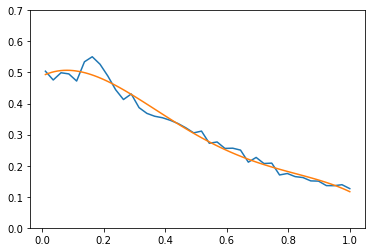

In [15]:
ps = [evaluateJointPrior(0.3,0.1,spline) for spline in reference_splines]
x = np.linspace(0.01,1.,100)
test = UnivariateSpline(reference_qs,ps,k=4,s=0.1)

fig,ax = plt.subplots()
ax.plot(reference_qs,ps)
ax.set_ylim(0,0.7)
ax.plot(x,test(x))

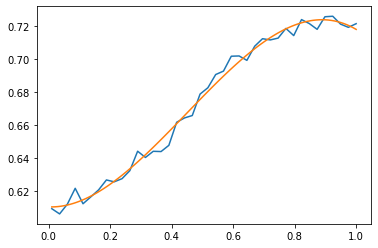

In [16]:
ps = [interp(0.3) for interp in reference_chiEff_interps]
x = np.linspace(0.01,1.,100)
test = UnivariateSpline(reference_qs,ps,k=3,s=0.1)

plt.plot(reference_qs,ps)
plt.plot(x,test(x))

In [19]:
O1O2_events = ['GW151012', 'GW170608', 'GW170729', 'GW151226', 'GW170814', 'GW150914', 'GW170104', 'GW170809', 'GW170818', 'GW170823']
for key in O1O2_events:
    
    print("##### {0}".format(key))
    
    # load samples
    BBH_post = h5py.File('./GWTC-1_sample_release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    m1_DF = BBH_post['m1_detector_frame_Msun']
    m2_DF = BBH_post['m2_detector_frame_Msun']
    a1 = BBH_post['spin1']
    a2 = BBH_post['spin2']
    cost1 = BBH_post['costilt1']
    cost2 = BBH_post['costilt2']
    Xeff = Calculate_Xeff(m1_DF,m2_DF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_DF,m2_DF,a1,a2,cost1,cost2)
    DL = BBH_post['luminosity_distance_Mpc']
    
    # Downselect to a reasonable number of samples
    nSamps = min(3000,Xeff.size)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_DF = m1_DF[sampleDraws]
    m2_DF = m2_DF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
    
    # Mass ratio
    q = m2_DF/m1_DF
    
    joint_priors = np.zeros(q.size)
    Xeff_priors = np.zeros(q.size)
    Xp_priors = np.zeros(q.size)
    for i in range(q.size):
        
        ref_joint_ps = [evaluateJointPrior(Xeff[i],Xp[i],spline) for spline in reference_splines]
        joint = UnivariateSpline(reference_qs,ref_joint_ps,k=3,s=0.1)
        joint_priors[i] = joint(q[i])
        
        ref_xeff_ps = [interp(Xeff[i]) for interp in reference_chiEff_interps]
        xeff_1d = UnivariateSpline(reference_qs,ref_xeff_ps,k=3,s=0.1)
        Xeff_priors[i] = xeff_1d(q[i])
        
        ref_xp_ps = [interp(Xp[i]) for interp in reference_chiP_interps]
        xp_1d = UnivariateSpline(reference_qs,ref_xp_ps,k=3,s=0.1)
        Xp_priors[i] = xp_1d(q[i])

    # Redshift and mass priors
    z = np.interp(DL,DL_ref,zs_ref)
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL,m1_DF,m2_DF)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    
    print(Xp_priors[Xp_priors<0])
    
    preprocDict = {'Xeff':Xeff,\
                        'Xp':Xp,\
                        'Xeff_priors':Xeff_priors,\
                        'Xp_priors':Xp_priors,\
                        'joint_priors':joint_priors,\
                        'weights':weights,\
                        'm1':m1_DF/(1.+z),\
                        'm2':m2_DF/(1.+z),\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2
                       }
    np.save('preprocessed_single_events/{0}.npy'.format(key),preprocDict)

##### GW151012
[]
##### GW170608
[]
##### GW170729
[]
##### GW151226
[]
##### GW170814
[]
##### GW150914
[]
##### GW170104
[]
##### GW170809
[]
##### GW170818
[]
##### GW170823
[]


In [20]:
O3_events = [
'S190408an',
'S190412m',
'S190413ac',
'S190413i',
'S190421ar',
'S190424ao',
'S190503bf',
'S190512at',
'S190513bm',
'S190514n',
'S190517h',
'S190519bj',
'S190521g',
'S190521r',
'S190527w',
'S190602aq',
'S190620e',
'S190630ag',
'S190701ah',
'S190706ai',
'S190707q',
'S190708ap',
'S190720a',
'S190727h',
'S190728q',
'S190731aa',
'S190803e',
'S190828j',
'S190828l',
'S190910s',
'S190915ak',
'S190924h',
'S190929d',
'S190930s']

with open('names.json','r') as jf:
    mappings = json.load(jf)
    
S_to_AB = {v:k for k,v in mappings['SNAME'].items()}
S_to_full = {k:mappings['FULLNAME'][v] for k,v in S_to_AB.items()}

In [22]:
sampleRelease = "./all_posterior_samples"
for key in O3_events:
    
    print(key)
        
    # Load samples
    f = h5py.File('{0}/{1}.h5'.format(sampleRelease,S_to_full[key]),'r')
    BBH_post_samples = f['PrecessingSpinIMRHM']['posterior_samples']

    m1_SF = np.squeeze(BBH_post_samples['mass_1_source'])
    m2_SF = np.squeeze(BBH_post_samples['mass_2_source'])
    a1 = np.squeeze(BBH_post_samples['a_1'])
    a2 = np.squeeze(BBH_post_samples['a_2'])
    cost1 = np.squeeze(BBH_post_samples['cos_tilt_1'])
    cost2 = np.squeeze(BBH_post_samples['cos_tilt_2'])
    DL = np.squeeze(BBH_post_samples['luminosity_distance'])
    z = np.squeeze(BBH_post_samples['redshift'])

    Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_SF,m2_SF,a1,a2,cost1,cost2)

    f.close()          
            
    # Downselect to a reasonable number of samples
    nSamps = min(3000,Xeff.size)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_SF = m1_SF[sampleDraws]
    m2_SF = m2_SF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    z = z[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
    
    # Mass ratio
    q = m2_SF/m1_SF
    
    joint_priors = np.zeros(q.size)
    Xeff_priors = np.zeros(q.size)
    Xp_priors = np.zeros(q.size)
    for i in range(q.size):
        
        ref_joint_ps = [evaluateJointPrior(Xeff[i],Xp[i],spline) for spline in reference_splines]
        joint = UnivariateSpline(reference_qs,ref_joint_ps,k=3,s=0.1)
        joint_priors[i] = joint(q[i])
        
        ref_xeff_ps = [interp(Xeff[i]) for interp in reference_chiEff_interps]
        xeff_1d = UnivariateSpline(reference_qs,ref_xeff_ps,k=3,s=0.1)
        Xeff_priors[i] = xeff_1d(q[i])
        
        ref_xp_ps = [interp(Xp[i]) for interp in reference_chiP_interps]
        xp_1d = UnivariateSpline(reference_qs,ref_xp_ps,k=3,s=0.1)
        Xp_priors[i] = xp_1d(q[i])

    # Redshift and mass priors
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL,m1_SF*(1+z),m2_SF*(1+z))
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    
    print(Xp_priors[Xp_priors<0])    
    
    preprocDict = {'Xeff':Xeff,\
                        'Xp':Xp,\
                        'Xeff_priors':Xeff_priors,\
                        'Xp_priors':Xp_priors,\
                        'joint_priors':joint_priors,\
                        'weights':weights,\
                        'm1':m1_SF,\
                        'm2':m2_SF,\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2
                       }
    np.save('preprocessed_single_events/{0}.npy'.format(key),preprocDict)

S190408an
[]
S190412m
[]
S190413ac
[]
S190413i
[]
S190421ar
[]
S190424ao
[]
S190503bf
[]
S190512at
[]
S190513bm
[]
S190514n
[]
S190517h
[]
S190519bj
[]
S190521g
[]
S190521r
[]
S190527w
[]
S190602aq
[]
S190620e
[]
S190630ag
[]
S190701ah
[]
S190706ai
[]
S190707q
[]
S190708ap
[]
S190720a
[]
S190727h
[]
S190728q
[]
S190731aa
[]
S190803e
[]
S190828j
[]
S190828l
[]
S190910s
[]
S190915ak
[]
S190924h
[]
S190929d
[]
S190930s
[]


In [23]:
sampleDict = {}
singleEvents = glob.glob('./preprocessed_single_events_/*')
for eventFile in singleEvents:
    
    if eventFile=="./preprocessed_single_events/priors.npy":
        continue
    
    key = re.split('\/|\.',eventFile)[-2]
    dataDict = np.load(eventFile,allow_pickle=True)[()]
    sampleDict[key] = dataDict

import pickle
with open('sampleDict_sampleRelease.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)

---
# Old